# Neural network in ```numpy```

#### 1. import dependencies and static variable definitions

In [1]:
# built-in packages
import os
import time
import gzip
import struct
import random
import logging
from functools import wraps

# 3rd party packages
import requests
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logging.getLogger("matplotlib").setLevel(logging.WARNING)


In [2]:
# static variable definitions

download_url = "http://yann.lecun.com/exdb/mnist/{}"

TRAINING_DATA_FILENAME = "train-images-idx3-ubyte.gz"
TRAINING_LABELS_FILENAME = "train-labels-idx1-ubyte.gz"
TEST_DATA_FILENAME = "t10k-images-idx3-ubyte.gz"
TEST_LABELS_FILENAME = "t10k-labels-idx1-ubyte.gz"

nb_epochs = 20
batch_size = 100
learning_rate = 0.01

#### 2. define helper functions

In [3]:
# helper function definitions

def configure_logger():
    """
    Set up logging.
    """
    default_format = u"%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    logging.basicConfig(level=logging.DEBUG, format=default_format)
    logger.debug("Starting logger.")


def timer(orig_func):
    """ 
    Decorator function that outputs time taken for execution of given function.

    :param orig_func: Any python function.
    :type local_path: function
    :returns:  function
    """
    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time()
        logger.debug('{} ran in {} sec.'.format(orig_func.__name__, t2 - t1))
        return result
    
    return wrapper

def download_from_url(url, local_namepath):
    """
    This function downloads resource at `url` to `local_namepath`.
    References: 
        - [https://gist.github.com/wy193777/0e2a4932e81afc6aa4c8f7a2984f34e2](https://gist.github.com/wy193777/0e2a4932e81afc6aa4c8f7a2984f34e2)

    :param url: URL to resource which has to be downloaded.
    :type url: str
    :param local_namepath: Path to local filename to store downloaded resource.
    :type local_namepath: str
    :returns:  int -- Size of downloaded resource.
    """
    file_size = int(requests.head(url).headers["Content-Length"])
    logger.debug(f"Resource at \"{url}\" has size {file_size}.")

    if os.path.exists(local_namepath):
        first_byte = os.path.getsize(local_namepath)
    else:
        first_byte = 0

    if first_byte >= file_size:
        logger.debug("File already exists?")
        return file_size
    
    header = {"Range": f"bytes={first_byte}-{file_size}"}
    pbar = tqdm(
        total=file_size, initial=first_byte,
        unit='B', unit_scale=True, desc=url.split('/')[-1])
    req = requests.get(url, headers=header, stream=True)
    with(open(local_namepath, 'ab')) as f:
        for chunk in req.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                pbar.update(1024)
    pbar.close()
    return file_size


def read_local_file_to_numpy(local_namepath):
    """
    Reads gzip files containing idx format files and returns numpy arrays.
    References:
        - [https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40](https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40)
        - [https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1](https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1)

    :param local_namepath: Namepath to local file to load into numpy array.
    :type local_namepath: str
    :returns:  numpy.ndarray

    """
    with gzip.open(local_namepath) as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        value =  np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
        logger.debug(f"Read array from {local_namepath} of shape {value.shape}.")
    return value

def visualize_data(x, y):
    """
    Selects a random indice from input 3D ndarray and plots image.
    
    :param x_train: Numpy array containing images.
    :type x_train: numpy.ndarray
    :param y_train: Numpy array containing labels.
    :type y_train: numpy.ndarray
   
    """
    t = random.randint(0, x.shape[0])
    fig = plt.imshow(x[t], cmap="gray", )
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(f"Label is {y[t]}")


In [4]:
configure_logger()

2018-08-10 03:29:46,081 - __main__ - DEBUG - Starting logger.


#### 3. get and visualize data

MNIST handwritten digit data available on [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

* **train-images-idx3-ubyte.gz**    :  training set images (9912422 bytes) 
* **train-labels-idx1-ubyte.gz**    :  training set labels (28881 bytes) 
* **t10k-images-idx3-ubyte.gz**     :   test set images (1648877 bytes) 
* **t10k-labels-idx1-ubyte.gz**     :   test set labels (4542 bytes)


In [5]:
_ = download_from_url(download_url.format(TRAINING_DATA_FILENAME), TRAINING_DATA_FILENAME)
_ = download_from_url(download_url.format(TRAINING_LABELS_FILENAME), TRAINING_LABELS_FILENAME)
_ = download_from_url(download_url.format(TEST_DATA_FILENAME), TEST_DATA_FILENAME)
_ = download_from_url(download_url.format(TEST_LABELS_FILENAME), TEST_LABELS_FILENAME)

2018-08-10 03:29:47,469 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): yann.lecun.com:80
2018-08-10 03:29:53,185 - urllib3.connectionpool - DEBUG - http://yann.lecun.com:80 "HEAD /exdb/mnist/train-images-idx3-ubyte.gz HTTP/1.1" 200 0
2018-08-10 03:29:53,190 - __main__ - DEBUG - Resource at "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz" has size 9912422.
2018-08-10 03:29:53,192 - __main__ - DEBUG - File already exists?
2018-08-10 03:29:53,196 - urllib3.connectionpool - DEBUG - Starting new HTTP connection (1): yann.lecun.com:80
2018-08-10 03:29:53,653 - urllib3.connectionpool - DEBUG - http://yann.lecun.com:80 "HEAD /exdb/mnist/train-labels-idx1-ubyte.gz HTTP/1.1" 200 0
2018-08-10 03:29:53,656 - __main__ - DEBUG - Resource at "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz" has size 28881.
2018-08-10 03:29:53,658 - __main__ - DEBUG - File already exists?
2018-08-10 03:29:53,662 - urllib3.connectionpool - DEBUG - Starting new HTTP connect

In [6]:
x_train = read_local_file_to_numpy(TRAINING_DATA_FILENAME)
y_train = read_local_file_to_numpy(TRAINING_LABELS_FILENAME)
x_test = read_local_file_to_numpy(TEST_DATA_FILENAME)
y_test = read_local_file_to_numpy(TEST_LABELS_FILENAME)

2018-08-10 03:29:56,161 - __main__ - DEBUG - Read array from train-images-idx3-ubyte.gz of shape (60000, 28, 28).
2018-08-10 03:29:56,163 - __main__ - DEBUG - Read array from train-labels-idx1-ubyte.gz of shape (60000,).
2018-08-10 03:29:56,210 - __main__ - DEBUG - Read array from t10k-images-idx3-ubyte.gz of shape (10000, 28, 28).
2018-08-10 03:29:56,212 - __main__ - DEBUG - Read array from t10k-labels-idx1-ubyte.gz of shape (10000,).


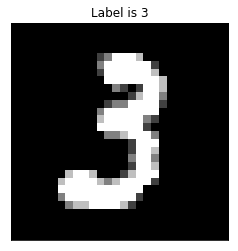

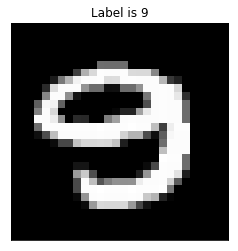

In [7]:
visualize_data(x_train, y_train)
plt.show()
visualize_data(x_train, y_train)
plt.show()

#### 4. build network forward propogation and backward propogation

In [8]:
nb_samples = x_train.shape[0]

input_layer_size = np.prod(x_train.shape[1:])
hidden_layer_size = 100
output_layer_size = 10

# https://towardsdatascience.com/random-initialization-for-neural-networks-a-thing-of-the-past-bfcdd806bf9e
Wih = np.random.randn(input_layer_size, hidden_layer_size)*np.sqrt(2/input_layer_size)
Bh = np.zeros(hidden_layer_size)

Who = np.random.randn(hidden_layer_size, output_layer_size)*np.sqrt(2/hidden_layer_size)
Bo = np.zeros(output_layer_size)

logger.debug(f"Weight matrix between input and hidden layer has shape {Wih.shape}.")
logger.debug(f"Weight matrix between hidden and output layer has shape {Who.shape}.")

2018-08-10 03:30:03,680 - __main__ - DEBUG - Weight matrix between input and hidden layer has shape (784, 100).
2018-08-10 03:30:03,681 - __main__ - DEBUG - Weight matrix between hidden and output layer has shape (100, 10).


In [17]:
t  =x_train[:100].reshape((100,-1))
(np.dot((np.dot(t, Wih) + Bh), Who)+Bo)

array([[  52.74321347,  103.74892584,  221.59772376,   -1.44463809,
         -10.33497032,  -30.26999531,   82.66128736,   56.80346911,
         -51.38870033, -241.22454567],
       [-107.19895111,   53.3345027 ,  144.186045  , -245.49581193,
        -340.99858845, -105.55303959,   77.09720127,   65.62373425,
        -164.87801842, -214.72536245],
       [ -39.84264686,   58.80129669,   83.30776404,   93.06578909,
         -69.07583572, -120.53254658,  140.9469097 ,    8.50708926,
         -58.47332796,  -43.40759903],
       [ 193.56502035,   44.84200076,   96.04901403,   -8.26388192,
        -116.51868383, -250.94671153, -235.81917807, -276.06100312,
         133.23447258, -179.75727495],
       [ -74.36214966, -126.33545624,  132.35460883,  -41.08769585,
          75.77029792,  -93.8093393 , -109.97478598, -244.71840433,
          90.84222912,  -46.47133939],
       [ -59.23646104,  -65.04774879,  225.67326187,   64.51419807,
         189.5038079 , -220.18060085,   -9.89445508,  -20

In [13]:
for epoch_num in range(nb_epochs):
    logger.debug(f"Beginning epoch {epoch_num+1} / {nb_epochs}.")
    
    for mini_batch_num in range(int(x_train.shape[0] / batch_size)):
        loss = 0
        logger.debug(f"Beginning mini-batch {mini_batch_num+1} / {int(x_train.shape[0] / batch_size)}.")
        
        mini_batch_x = x_train[mini_batch_num*batch_size:(mini_batch_num+1)*batch_size]
        mini_batch_x = mini_batch_x.reshape((batch_size, input_layer_size)) / 255.0
        
        mini_batch_y = np.zeros((batch_size, output_layer_size))
        mini_batch_y[np.arange(batch_size), y_train[mini_batch_num*batch_size:(mini_batch_num+1)*batch_size]] = 1 # https://stackoverflow.com/a/29831596
        
        mini_batch_pred = (np.dot((np.dot(mini_batch_x, Wih) + Bh), Who)+Bo)
        
        # https://stackoverflow.com/a/34969389
        mini_batch_pred = np.exp(mini_batch_pred - np.max(mini_batch_pred))
        mini_batch_pred = mini_batch_pred / mini_batch_pred.sum()
        
        loss += -1.0 * np.sum(mini_batch_y* np.log(mini_batch_pred))
        logger.debug(f"Loss for mini batch is {loss}.")
        
        
        logger.debug(f"Ending mini-batch {mini_batch_num+1} / {int(x_train.shape[0] / batch_size)}.")
        
        logger.debug(f"Got loss {loss} .")
    logger.debug(f"Ending epoch {epoch_num+1} / {nb_epochs}.")
    break

2018-08-10 03:32:53,605 - __main__ - DEBUG - Beginning epoch 1 / 20.
2018-08-10 03:32:53,607 - __main__ - DEBUG - Beginning mini-batch 1 / 600.
2018-08-10 03:32:53,614 - __main__ - DEBUG - Loss for mini batch is 705.8574161356412.
2018-08-10 03:32:53,616 - __main__ - DEBUG - Ending mini-batch 1 / 600.
2018-08-10 03:32:53,617 - __main__ - DEBUG - Got loss 705.8574161356412 .
2018-08-10 03:32:53,618 - __main__ - DEBUG - Beginning mini-batch 2 / 600.
2018-08-10 03:32:53,622 - __main__ - DEBUG - Loss for mini batch is 703.6934416053015.
2018-08-10 03:32:53,623 - __main__ - DEBUG - Ending mini-batch 2 / 600.
2018-08-10 03:32:53,623 - __main__ - DEBUG - Got loss 703.6934416053015 .
2018-08-10 03:32:53,624 - __main__ - DEBUG - Beginning mini-batch 3 / 600.
2018-08-10 03:32:53,627 - __main__ - DEBUG - Loss for mini batch is 707.3727831394797.
2018-08-10 03:32:53,628 - __main__ - DEBUG - Ending mini-batch 3 / 600.
2018-08-10 03:32:53,628 - __main__ - DEBUG - Got loss 707.3727831394797 .
2018-08

In [74]:
t = x_train[:100]/255.0
t.shape

(10, 28, 28)

In [75]:
t = t.reshape((10,784))

In [76]:
t.shape

(10, 784)

array([[ 0.68145922,  1.0112613 ,  0.61573816, -0.45880615, -1.35047426,
        -0.12518257,  0.88719588,  0.0964988 ,  0.27196918,  1.2945905 ],
       [ 0.62708846,  0.33809841,  1.15800659, -0.06743651, -0.8464111 ,
        -0.05961776, -0.25045429, -0.19081354,  0.01034638,  0.48584906],
       [-0.2059416 ,  0.50221914,  1.1407093 ,  1.06378912, -1.85049835,
        -1.21638051,  1.17264628,  0.12136411,  0.01111485,  1.25383258],
       [-0.6375463 , -0.76506485,  0.36751343,  0.29505475, -1.13132545,
        -0.48853039, -0.20288876,  0.58729835,  0.07473017,  1.33243217],
       [-1.20439491, -0.41065335,  0.16837524, -0.41966222, -1.0408778 ,
        -0.25208825, -0.13848511, -1.05910164, -0.1193719 ,  0.98001406],
       [-0.49004632,  1.18433013,  0.20573272,  0.25209608, -0.7712663 ,
        -0.45438498,  0.38739872,  0.17851353, -0.03856744,  0.22358068],
       [-0.59839865,  0.54265546,  0.21142778,  0.34258556, -1.19748836,
        -0.17126686,  0.29109319,  0.39073437

In [38]:
y_train[:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)